In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, detrend, find_peaks, convolve
from scipy.fft import fft, fftfreq

module_path = os.path.abspath(os.path.join('..', 'src', 'dlc_analysis'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.dlc_analysis.utils import compute_derivative, get_body_center
from src.dlc_analysis.utils import compute_base_and_heading, compute_turn_angles
from src.dlc_analysis.utils import quick_smooth, find_repeats, process_bout_overlaps

In [3]:
# dlc_df = pd.read_hdf(r'C:\Users\lscholz\Downloads\Examples\Block1_baseline0DLC_resnet152_ZF-RoscoSep13shuffle1_5400000.h5')
# dlc_df = pd.read_hdf(r'C:\Users\lscholz\Downloads\Examples\Block1_Loom0DLC_resnet152_ZF-RoscoSep13shuffle1_5400000.h5')
# dlc_df = pd.read_hdf(r'C:\Users\lscholz\Downloads\Examples\Block1_Loom3DLC_resnet152_ZF-RoscoSep13shuffle1_5400000.h5')
# scorer = 'DLC_resnet152_ZF-RoscoSep13shuffle1_5400000'

dlc_df = pd.read_hdf(r'..\demo_dlc_output.h5')
scorer = dlc_df.columns.get_level_values(0)[0]

FPS = 300

In [ ]:
def get_point_metrics(dataframe : pd.DataFrame,
                      bodypart : str,
                      mask=None,
                      px_tolerances=(0.0, 1000),
                      movavg=None, **kwargs):
    """ Computes point-based metrics from a pd.DataFrame with a dlc result structure.  
        Calcualates normalized x and y positions, distance from image center (for square videos),
         distance travelled, speeds and acceleration.
        Variable names: 
            'x', 'y', 'x_norm', 'y_norm', 'likelihood', 'dist_travelled',
            'velocity', 'acceleration', 'dist_to_center'
        additional variables (if 'movavg' is in kwargs)
            'x_smooth', 'y_smooth', 'x_norm_smooth', 'y_norm_smooth',
            'dist_travelled_smooth', 'velocity_smooth', 'acceleration_smooth',
            'dist_to_center_smooth'
    Args:
        dataframe (pd.DataFrame): dataframe in the same structure of a dlc output from h5/csv file.
        bodypart (str): str with the name of the body part in the dataframe to be used to compute 
            the point metrics. after getting body center, we tend to use 'mean_body_keypoint' but 
            you can use an existing keypoint if you prefer (e.g. 'swim_bladder')
        mask (np.ndarray): a boolean mask that will filter out unwanted datapoints. 
        px_tol (tuple): two-element tuple with a low and high distance travelled (in pixels) 
            tolerance. Values lower than the first element and values higher than the second
            element, will be set to zero. 
    kwargs:
        'resolution' (float) : resolution in mm per pixel of the video that originated the dlc
            result file. 
        'frame_size' (int): width/height of the video frames (currently this calculation is only
            meaningful for square videos width=height)
        'fps' (int): framerate of the video that originated the dlc result file
        'movavg' (int): window size (in frames) to compue smoothed coordinates 
    Returns:
        pd.DataFrame : result dataframe with all the point metrics
    """

    ### I think it may make sense to change the output of this function to be a dictionary
    scorer = dataframe.columns.get_level_values(0)[0]

    # Process kwargs
    if 'resolution' in kwargs:
        RESOLUTION = kwargs['resolution']
    else:
        Warning('Image resolution not given, distance and velocity results will be in px')
        RESOLUTION = 1.0

    if 'frame_size' in kwargs:
        if kwargs['frame_size'] is not None:
            FRAME_SIZE = kwargs['frame_size']
        else:
            Warning("""Frame size (px) is None, point coordinate will not be 
                     and distance to center calculations will be incorrect""")
            FRAME_SIZE = 1.0
    else:
        Warning("""Frame size (px) not given, point coordinate will not be normalized
                and distance to center calculations will be incorrect""")
        FRAME_SIZE = 1.0

    if 'fps' in kwargs:
        if kwargs['fps'] is not None:
            FPS = kwargs['fps']
        else:
            Warning('FPS is none. Velocity calculations will be computed using dt = 1 s')
            FPS = 1.0
    else:
        Warning('FPS was not given. Velocity calculations will be computed using dt = 1 s')
        FPS = 1.0

    # but are also incorrectly detected to be in (0,0) point in the video
    # thus, it is necessary to remove those
    if mask is None:
        # just find points that are not (0,0) 
        mask = np.all(dataframe[scorer][bodypart][['x', 'y']].values != 0, axis=1)
    else:
        non_zero_rows = np.all(dataframe[scorer][bodypart][['x', 'y']].values != 0, axis=1)
        mask = np.logical_and(mask, non_zero_rows)

    # note for the future: As of now, moving average does not take into account whether the
    # points are from consecutive frames or not, if many datapoints are lost due to incorrect 
    # dlc detection (e.g. point (0,0) but high likelihood). this may be an issue
    # as the moving averages will show considerable movement but the fish really isnt moving it 
    # may be good to implement a moving average for chunks of consecutive frames

    # now, the result will have the same size (number of data points)
    # as the dlc output, but the filtered points will be populated with nans
    n_time_pts = len(dataframe)
    frames = np.arange(n_time_pts)
    times = frames*(1/FPS)
    time_array = np.full((n_time_pts,2), np.nan)
    time_array[mask, 0] = frames[mask]
    time_array[mask, 1] = times[mask]

    coords = np.full(dataframe[scorer][bodypart][['x', 'y']].values.shape, np.nan)
    coords[mask, :] = dataframe[scorer][bodypart][['x', 'y']].values[mask]

    likelihood = np.full(dataframe[scorer][bodypart]['likelihood'].values.shape, np.nan)
    likelihood[mask] = dataframe[scorer][bodypart]['likelihood'].values[mask]

    # CREATE THE SAME STUFF WITH NANS FOR THE RESULTS
    dist = np.full((time_array.shape[0], ), np.nan)
    velocities = np.full((time_array.shape[0], ), np.nan)
    acceleration = np.full((time_array.shape[0], ), np.nan)
    coords_norm = np.full((time_array.shape[0],2), np.nan)
    dist_to_center = np.full((time_array.shape[0], ), np.nan)

    # Clean dist and velocities using the px_tol which are to minimize flickering in in the low end
    # and incorrect detection of keypoints due to artifacts in the frame in the high end
    x_diff = compute_derivative(coords[mask, 0])
    y_diff = compute_derivative(coords[mask, 1])
    dist[mask] = np.sqrt(x_diff**2 + y_diff**2)
    dist[dist < px_tolerances[0]] = 0.0
    dist[dist > px_tolerances[1]] = 0.0
    dist = dist * RESOLUTION

    # calculate velocities and acceleration
    v_x = compute_derivative(coords[mask, 0], x=time_array[mask, 1])
    v_y = compute_derivative(coords[mask, 1], x=time_array[mask, 1])
    velocities[mask] = np.sqrt(v_x**2 + v_y**2)
    velocities = velocities * RESOLUTION
    acceleration[mask] = compute_derivative(velocities[mask], x=time_array[mask,1])

    # calulate the normalized coordinates with 0,0 being the center
    # of the frame, -1, 1 being edges of the frame
    # which are always approximately the edge of the circular well (+- 1 mm)
    #coords_norm = (coords - (FRAME_SIZE/2))/ (FRAME_SIZE/2)
    coords_norm[mask, :] = (coords[mask, :] - (FRAME_SIZE/2))/ (FRAME_SIZE/2)

    diff_to_center = coords[mask, :] - np.array([(FRAME_SIZE/2), (FRAME_SIZE/2)])
    dist_to_center[mask] = np.sqrt(np.sum(diff_to_center**2, axis=1)) * RESOLUTION

    # define column names
    row_1 = ['Frame',
             'Time',
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart]
    row_2 = ['Frame',
             'Time',
             'x',
             'y',
             'x_norm',
             'y_norm',
             'likelihood',
             'dist_travelled',
             'velocity',
             'acceleration',
             'dist_to_center']

    if movavg is not None:

        coords_smooth = np.full(dataframe[scorer][bodypart][['x', 'y']].values.shape, np.nan)
        coords_smooth[mask, :] = dataframe[scorer][bodypart][['x', 'y']].values[mask]

        if (kwargs['movavg'] % 2) == 0:
            temp_coords = np.vstack((np.repeat(coords_smooth[mask,:][0].reshape(1,2),
                                               int((kwargs['movavg']-1)/2), axis=0),
                                               coords_smooth[mask,:],
                                     np.repeat(coords_smooth[mask,:][-1].reshape(1,2),
                                               int(kwargs['movavg']/2), axis=0)))
        if (kwargs['movavg'] % 2) == 1:
            temp_coords = np.vstack((np.repeat(coords_smooth[mask,:][0].reshape(1,2),
                                               int(kwargs['movavg']/2), axis=0),
                                               coords_smooth[mask,:],
                                     np.repeat(coords_smooth[mask,:][-1].reshape(1,2),
                                               int(kwargs['movavg']/2), axis=0)))

        x_coords = np.convolve(temp_coords[:,0], np.ones(kwargs['movavg']),
                               mode='valid') / kwargs['movavg']
        y_coords = np.convolve(temp_coords[:,1], np.ones(kwargs['movavg']),
                               mode='valid') / kwargs['movavg']
        coords_smooth[mask, :] = np.column_stack((x_coords, y_coords))

        #same block of calculations done with the smoothed coordinates
        dist_smooth =  np.full((time_array.shape[0],), np.nan)
        velocities_smooth =  np.full((time_array.shape[0], ), np.nan)
        acceleration_smooth =  np.full((time_array.shape[0], ), np.nan)
        coords_norm_smooth = np.full((time_array.shape[0], 2), np.nan)
        dist_to_center_smooth =  np.full((time_array.shape[0], ), np.nan)

        x_smooth_diff = compute_derivative(coords_smooth[mask, 0])
        y_smooth_diff = compute_derivative(coords_smooth[mask, 1])
        dist_smooth[mask] = np.sqrt(x_smooth_diff**2 + y_smooth_diff**2)
        dist_smooth[dist_smooth < px_tolerances[0]] = 0.0
        dist_smooth[dist_smooth > px_tolerances[1]] = 0.0
        dist_smooth = dist_smooth * RESOLUTION

        # calculate velocities and acceleration
        v_x = compute_derivative(coords_smooth[mask, 0], x=time_array[mask])
        v_y = compute_derivative(coords_smooth[mask, 1], x=time_array[mask])
        velocities_smooth[mask] = np.sqrt(v_x**2 + v_y**2)
        velocities_smooth = velocities_smooth * RESOLUTION
        acceleration_smooth[mask] = compute_derivative(velocities_smooth[mask], x=time_array[mask])

        coords_norm_smooth[mask, :] = (coords_smooth[mask, :] - (FRAME_SIZE/2))/ (FRAME_SIZE/2)
        diff_to_center_smooth = coords_smooth[mask, :] - np.array([(FRAME_SIZE/2), (FRAME_SIZE/2)])
        dist_to_center_smooth[mask] = np.sqrt(np.sum(diff_to_center_smooth**2, axis=1)) * RESOLUTION

        # define column names
        row_1.extend([bodypart]*8)
        row_2.extend(['x_smooth',
                      'y_smooth',
                      'x_norm_smooth',
                      'y_norm_smooth',
                      'dist_travelled_smooth',
                      'velocity_smooth',
                      'acceleration_smooth',
                      'dist_to_center_smooth'])

    results_structure = [row_1,
                         row_2]
    tuples = list(zip(*results_structure))
    results_structure = pd.MultiIndex.from_tuples(tuples)
    df = pd.DataFrame(columns=results_structure)

    df[[('Frame', 'Frame'), ('Time', 'Time')]] = time_array
    df[bodypart,'x'] = coords[:, 0]
    df[bodypart,'y'] = coords[:, 1]
    df[bodypart,'x_norm'] = coords_norm[:,0]
    df[bodypart,'y_norm'] = coords_norm[:,1]

    df[bodypart,'likelihood'] = likelihood
    df[bodypart,'dist_travelled'] = dist
    df[bodypart,'velocity'] = velocities
    df[bodypart,'acceleration'] = acceleration
    df[bodypart,'dist_to_center'] = dist_to_center

    if movavg is not None:
        df[bodypart, 'x_smooth'] = coords_smooth[:, 0]
        df[bodypart, 'y_smooth'] = coords_smooth[:, 1]
        df[bodypart, 'x_norm_smooth'] = coords_norm_smooth[:, 0]
        df[bodypart, 'y_norm_smooth'] = coords_norm_smooth[:, 1]
        df[bodypart, 'dist_travelled_smooth'] = dist_smooth
        df[bodypart, 'velocity_smooth'] = velocities_smooth
        df[bodypart, 'acceleration_smooth'] = acceleration_smooth
        df[bodypart, 'dist_to_center_smooth'] = dist_to_center_smooth

    return df

def get_vector_metrics(dataframe: pd.DataFrame, keypoints_to_vectors : list, mask=None, **kwargs):
    """ Compute all vector-based metrics 

    Args:
        dataframe ([type]): [description]
        keypoints_to_vectors (tuple): two-element tuple with lists of 
            str ontaining the two points to define the animal's heading.
            e.g. (['swim_bladder'], ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom'])
            the first set of keypoints determines the origin of the heading vector, and the second 
            set defines the its 'tip'.

    kwargs:
        'truncate' (int) : calculate vector metrics using fewer tail points by setting truncate 
            value to a number lower than 10 (10 is the total number of tail points). 
        'fps' (int): framerate of the video that originated the dlc result file
        'smooth' (int): window size, in frames (smooth > 3), with which to smooth the tail segment
            angle and heading angle data. Uses the savitzky-golay filter (polyorder=3). 
            This will help smooth the mean tail curvature metrics (mtc, mtc_velocity, mtc_accel)
    Returns:
        pd.DataFrame: full dataframe with the vector metrics results
    """

    ### I think it may make sense to change the output of this function to be a dictionary
    origin, point = keypoints_to_vectors

    scorer = dataframe.columns.get_level_values(0)[0]

    if 'truncate' in kwargs:
        TRUNCATE_TAIL_SEGS = kwargs['truncate']
    else: 
        TRUNCATE_TAIL_SEGS = 10

    if 'fps' in kwargs:
        if kwargs['fps'] is not None:
            FPS = kwargs['fps']
        else: 
            Warning('FPS is None. Velocity calculations will be computed using dt = 1 s')
            FPS = 1.0
    else:
        Warning('FPS was not given. Velocity calculations will be computed using dt = 1 s')
        FPS = 1.0

    if 'smooth' in kwargs:
        SMOOTH = kwargs['smooth']
    else: 
        SMOOTH = None

    N_TIME_PTS = len(dataframe)
    if mask is None:
        mask = np.full((N_TIME_PTS,), 1).astype(bool)

    frames = np.arange(N_TIME_PTS).reshape((-1,1))
    times = frames*(1/FPS)
    time_array = np.hstack([frames[mask],times[mask]]).reshape((-1,2))

    df = compute_base_and_heading(dataframe,
                                  time_array,
                                  origin,
                                  point,
                                  truncate=TRUNCATE_TAIL_SEGS,
                                  smooth=SMOOTH)
    df = compute_turn_angles(df)

    # add new columns to df so it later receives the outputs from compute_tail_curvature_metrics()
    results_structure = [[],[]]
    for i in range(1,TRUNCATE_TAIL_SEGS+1):
        results_structure[0].extend(['tail_vector_' + str(i), 'tail_vector_' + str(i)])
    for i in range(1,TRUNCATE_TAIL_SEGS+1):
        results_structure[0].extend(['tail_angle_' + str(i)])

    results_structure[1].extend(['x', 'y'] * TRUNCATE_TAIL_SEGS)
    results_structure[1].extend(['angle'] * TRUNCATE_TAIL_SEGS)
    results_structure[0].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
    results_structure[1].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
    tuples = list(zip(*results_structure))

    for column in tuples:
        df[column] = np.nan

    # prepare inputs for compute_tail_curvature_metrics()
    heading_vector = df.iloc[:,6:8].values
    tail_list = []

    for coord in ['x', 'y']:
        tail_list.append(('swim_bladder', coord))
    for i in range(1,TRUNCATE_TAIL_SEGS+1):
        for coord in ['x', 'y']:
            tail_list.append(('tail_'+str(i), coord))

    mtc_metrics = compute_tail_curvature_metrics(heading_vector,
                                                 time_array,
                                                 dataframe[scorer][tail_list].values,
                                                 truncate=TRUNCATE_TAIL_SEGS,
                                                 smooth=SMOOTH)

    for key, values in mtc_metrics.items():
        df[key] = values

    return df

def compute_tail_curvature_metrics(heading_vector : np.ndarray,
                                   time_array : np.ndarray,
                                   tail_points : np.ndarray,
                                   truncate=None,
                                   **kwargs):
    """_summary_

    Args:
        heading_vector (np.ndarray): normalized heading vector matrix (n-by-2)
        tail_points (np.ndarray): tail points coordinate matrix, if using our dlc model
        it is commonly shape n-by-22 (swim bladder + 10 tail point coordinates)
        truncate (int, optional): tail point number where tail angles and mean tail point 
            calculation will be truncated (example, truncate of 8 will only use the 
            first 8 tail points for angles and mean tail curvature calculation). 
            Defaults to None. If none uses all tail points to 
            calculate tail angles and mean tail curvature.
    kwargs:
        'smooth' (int): window size, in frames (smooth > 3), with which to smooth the tail 
            segment angle data. Uses the savitzky-golay filter (polyorder=3). 
            This will help smooth the mean tail curvature metrics (mtc, mtc_velocity, mtc_accel)
    
    Raises:
        ValueError: If the num. of observations in heading vector (rows) does not match num. obs.
            (rows) in tail_points, stop computations.

    Returns:
        dictionary: dictionary with two keys: 'tail_angles' and 'mtc', containing with tail angles 
            (n-by-m, m=truncate) and mean tail curvature results (n-by-1), respectively.
    """

    n_obs, n_cols = tail_points.shape

    if 'smooth' in kwargs:
        SMOOTH = kwargs['smooth']
    else:
        SMOOTH = None

    if truncate is None:
        truncate = int((n_cols/2 - 1))

    #print(f"truncate value is now {truncate} and number of tail points is {n_cols/2-1}")

    diff = int((n_cols/2 -1) - truncate)

    # print(f"""difference in number of tail points to truncate and actual
    #           number of tail points: {diff}""")

    if diff != 0:
        stop_point = - diff*2
        tail_vectors = tail_points[:, 2:stop_point] - tail_points[:, :stop_point-2]
    else:
        tail_vectors = tail_points[:, 2:] - tail_points[:, :-2]

    n_obs, n_cols = tail_vectors.shape

    # reshape data in a way that we can compute the angles efficiently
    flat_tail_vectors = tail_vectors.reshape((-1,2))

    repeated_hvs = np.tile(-heading_vector, (1,truncate))
    repeated_hvs = repeated_hvs.reshape((-1,2))

    #check if shapes match, otherwise stop computation
    if flat_tail_vectors.shape != repeated_hvs.shape:
        raise ValueError("Tail vectors not the same size as repeated heading vectors")

    #add the third dimension populated with zeros for the cross product
    repeated_hvs = np.hstack((repeated_hvs, np.zeros((repeated_hvs.shape[0],1))))

    #normalize tail vectors and add third dimension populated with zeros for cross product
    flat_tail_vectors = flat_tail_vectors / np.reshape(np.linalg.norm(flat_tail_vectors, axis=1), \
                                                       (-1, 1))
    flat_tail_vectors = np.hstack((flat_tail_vectors, np.zeros((flat_tail_vectors.shape[0],1))))

    # compute tail angles with respect to inverted heading vector
    dot_product = np.einsum('ij,ij->i', flat_tail_vectors, repeated_hvs)
    cross_product = np.cross(flat_tail_vectors, repeated_hvs)
    dot_with_cross = np.dot(cross_product, [0, 0, 1])
    tail_angles = np.reshape(np.arctan2(dot_with_cross, dot_product), (-1, truncate))

    tail_angles = np.degrees(tail_angles)

    # compute mean tail curvature
    if SMOOTH is not None:
        print("smoothing tail angles")
        tail_angles = savgol_filter(tail_angles, SMOOTH, polyorder=3, axis=0)
    mean_tail_curvature = np.mean(tail_angles, axis=1)

    full_output = {'tail_vectors': flat_tail_vectors[:,:2].reshape((n_obs, truncate*2)),
                   'tail_angles': tail_angles,
                   'mtc': mean_tail_curvature}

    results_structure = [[],[]]

    for i in range(1,truncate+1):
        results_structure[0].extend(['tail_vector_' + str(i), 'tail_vector_' + str(i)])
    for i in range(1,truncate+1):
        results_structure[0].extend(['tail_angle_' + str(i)])

    results_structure[1].extend(['x', 'y'] * truncate)
    results_structure[1].extend(['angle'] * truncate)
    results_structure[0].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
    results_structure[1].extend(['mtc', 'mtc_velocity', 'mtc_accel'])

    mtc_velocity = compute_derivative(mean_tail_curvature, x=time_array[:,1], pad=True)
    mtc_accel = compute_derivative(mtc_velocity, x=time_array[:,1], pad=True)

    tuples = list(zip(*results_structure))
    results_structure = pd.MultiIndex.from_tuples(tuples)
    df = pd.DataFrame(data=np.hstack([full_output['tail_vectors'],
                                      full_output['tail_angles'],
                                      full_output['mtc'].reshape((-1,1)),
                                      mtc_velocity.reshape((-1,1)),
                                      mtc_accel.reshape((-1,1))]), columns=results_structure)

    return df

def get_all_metrics(dataframe : pd.DataFrame,
                    exp_metadata: dict,
                    bodyparts_dict: dict,
                    pcutoff=0.8,
                    mask=None,
                    px_tolerances=(0,1000),
                    **kwargs) -> pd.DataFrame:

    """ Computes all point- and vector-based metrics from a dlc output dataframe

    Args:
        dataframe (pd.DataFrame): _description_
        exp_metadata (_type_): _description_
        bodyparts_dict (_type_): _description_
        pcutoff (float, optional): _description_. Defaults to 0.8.
        mask (np.ndarray, bool, optional): mask to filter particular time interval of the 
            dlc dataframe. Has to have the same length as the dataframe (len(mask)==len(dataframe)).
            Defaults to None.
        px_tolerances (tuple, optional): _description_. Defaults to (0,1000).

    kwargs: 
        'point_movavg': window size (in frames) to compue smoothed coordinates using a
             moving average. 
        'vector_smooth': window size, in frames (vector_smooth > 3), with which to smooth the tail 
            segment angle data. Uses the savitzky-golay filter (polyorder=3). 
            This will help smooth the mean tail curvature metrics (mtc, mtc_velocity, mtc_accel)
        'truncate_tail_pts': calculate vector metrics using fewer tail points by trunacting the 
            number of tail points (10 is the total number of tail points). 

    Raises:
        TypeError: _description_

    Returns:
        pd.DataFrame: _description_
    """
    # process kwargs
    if 'point_movavg' in kwargs:
        MOVAVG = kwargs['point_movavg']
    else:
        MOVAVG = None

    if 'vector_smooth' in kwargs:
        SMOOTH = kwargs['vector_smooth']
    else:
        SMOOTH = None
    
    if 'truncate_tail_pts' in kwargs:
        TRUNCATE = kwargs['truncate_tail_pts']
    else:
        TRUNCATE = 10

    # store metadata 
    if isinstance(exp_metadata, dict):
        RESOLUTION = exp_metadata['experiment_specs']['resolution_mmpx']
        FPS = int(exp_metadata['camera_specs']['frame_rate'])
        FRAME_SIZE = int(exp_metadata['camera_specs']['width'])
    else:
        raise TypeError("""exp_metadata not type dict. This new version of the function takes
                        exp_metadata as dictionary.""")

    N_TIME_PTS = len(dataframe)
    if mask is not None:
        if len(mask) != len(dataframe):
            raise ValueError("mask has to have the same length as dataframe")
    if mask is None:
        mask = np.full((N_TIME_PTS,), 1).astype(bool)

    if len(bodyparts_dict['point_metrics']) > 1:
        mean_body_kpoint_df = get_body_center(dataframe[mask],
                                              bodyparts_dict['point_metrics'],
                                              pcutoff=pcutoff)

        dataframe = pd.concat([dataframe[mask], mean_body_kpoint_df], axis=1)

        point_metrics_df = get_point_metrics(dataframe,
                                             bodypart='mean_body_keypoint',
                                             mask=mask,
                                             px_tolerances=px_tolerances,
                                             resolution=RESOLUTION,
                                             frame_size=FRAME_SIZE,
                                             fps=FPS,
                                             movavg=MOVAVG)

    if len(bodyparts_dict['point_metrics']) == 1:
        point_metrics_df = get_point_metrics(dataframe[mask],
                                             bodypart=bodyparts_dict['point_metrics'],
                                             mask=mask,
                                             px_tolerances=px_tolerances,
                                             resolution=RESOLUTION,
                                             frame_size=FRAME_SIZE,
                                             fps=FPS,
                                             movavg=MOVAVG)

    vector_metrics_df = get_vector_metrics(dataframe[mask],
                                           keypoints_to_vectors=bodyparts_dict['vector_metrics'],
                                           fps=FPS,
                                           truncate=TRUNCATE,
                                           smooth=SMOOTH)

    all_metrics_df = pd.concat([point_metrics_df, vector_metrics_df], axis=1)
    all_metrics.sort_index(axis=1, inplace=True)
    
    return all_metrics_df

def bout_detector(
    all_metrics,
    frame_rate,
    smooth_window=9,
    min_peak_separation=0.05,
    min_peak_prominence=0.01,
    bout_window_start=60,
    bout_window_end=100,
    accel_threshold=5,
    mtc_std_threshold=0.5,
    num_repeats=8,
) -> dict:
    """
    detects the onset and offset of swim bouts using the dataframe output from get_all_metrics()
    Args:
        point_metrics (dict): Dictionary containing point-based kinematic data,
                              including 'distance_mm', 'velocity', and 'acceleration'.
        vector_metrics (dict): Dictionary containing vector-based metrics, including
                               'mean_tail_vel', 'mean_tail_angle', and 'delta_heading'.
        frame_rate (int): The video frame rate in Hz.
        smooth_window (int, optional): The size of the smoothing window. Defaults to 5.
        min_peak_separation (float, optional): Minimum time in seconds between movement peaks. 
            Defaults to 0.05.
        min_peak_prominence (float, optional): Minimun prominence of a peak to be considered 
            a valid bout. Defaults to 0.01.
        bout_window_start (int, optional): Number of frames to look back from a peak to 
            find the start. Defaults to 60.
        bout_window_end (int, optional): Number of frames to look forward from a peak to
            find the end. Defaults to 100.
        accel_threhold (float, optional): body acceleration threshold to find end of the bout. 
            Defaults to 5.
        mtc_std_threshold (float, optional): mean tail curvature standard deviation threshold 
            to find end of the bout. Defaults to 0.5.
        num_repeats (int, optional): Number of consecutive frames of low/zero movement to 
            define start/end. Defaults to 7.


    Returns:
        dict: A dictionary containing various metrics for each detected bout.
    """
    # Get main keypoint name
    keypt_name = all_metrics.columns.get_level_values(0)[2]
    # Grab point metrics
    distance_mm = all_metrics[(keypt_name, 'dist_travelled')].values
    acceleration = all_metrics[(keypt_name, 'acceleration')].values

    # Locate the bouts
    distance_mm_smoothed = quick_smooth(distance_mm, smooth_window)
    acceleration_smoothed = quick_smooth(acceleration, smooth_window)

    peaks, _ = find_peaks(distance_mm_smoothed,
                          distance=min_peak_separation * frame_rate,
                          prominence=min_peak_prominence)

    # Adjust peak locations to account for smoothing window
    locs = peaks + (smooth_window - 1) // 2

    # 3. Filter bouts
    # Remove bouts too close to start/end
    valid_indices = (locs > bout_window_start) & (locs + bout_window_end < len(distance_mm))
    trimmed_locs = locs[valid_indices]

    # Remove bouts with bad tracking (too many NaNs)
    bad_bouts = []
    for i, loc in enumerate(trimmed_locs):
        start_win = loc - bout_window_start
        end_win_start = loc + bout_window_end

        window_before = distance_mm[start_win:loc]
        window_after = distance_mm[loc:end_win_start]

        nan_ratio_before = np.sum(np.isnan(window_before)) / len(window_before)
        nan_ratio_after = np.sum(np.isnan(window_after)) / len(window_after)

        if nan_ratio_before >= 0.5 or nan_ratio_after >= 0.5:
            bad_bouts.append(i)

    trimmed_locs = np.delete(trimmed_locs, bad_bouts)

    # 4. Determine bout start
    bout_start_locs = []
    for loc in trimmed_locs:
        window_of_interest = distance_mm_smoothed[(loc - bout_window_start):loc]
        # To handle NaNs pythonically, we create a temporary version of the
        # window where NaNs are replaced with a value that won't affect logic (e.g., infinity).
        # This avoids modifying the original data with a "magic number".
        window_for_repeats = np.nan_to_num(window_of_interest, nan=np.inf)
        repeat_array = find_repeats(window_for_repeats)

        # Find last sequence of repeats or zero movement
        # The condition for `window_of_interest == 0` is checked on the original data.
        start_candidates = np.where((repeat_array >= num_repeats) & (window_of_interest == 0))[0]
        if start_candidates.size > 0:
            start_temp = (loc - bout_window_start) + np.max(start_candidates)
        else: # If not found, use max change in acceleration
            accel_change = acceleration_smoothed[(loc - bout_window_start):loc]
            max_i = np.argmax(accel_change) if accel_change.size > 0 else 0
            start_temp = (loc - bout_window_start) + max_i
        bout_start_locs.append(start_temp)

    bout_start_locs = np.array(bout_start_locs)

    # Filter out bouts where start is after peak
    valid_indices = (trimmed_locs - bout_start_locs) > 0
    trimmed_locs = trimmed_locs[valid_indices]
    bout_start_locs = bout_start_locs[valid_indices]

    # 5. Determine bout end (distance-based)
    bout_end_locs = []
    for i, loc in enumerate(trimmed_locs):
        # Strategy from `find_end` function
        window_of_interest = distance_mm_smoothed[loc:(loc + bout_window_end)].copy()

        # we divide acceleration by 10k, mtd_std by 100 to put them in the same order of magnitude
        # this is not necessary if you do not want to see the data in the same plot
        window_accel = np.absolute(acceleration_smoothed[loc:(loc + bout_window_end)])/10000
        window_mtc_std = all_metrics[('mtc', 'mtc')][loc:(loc + bout_window_end)] \
            .rolling(smooth_window).std()/100
        window_mtc_std = window_mtc_std.values.reshape((-1,))

        end_found = False
        # Iteratively search for minimum that meets criteria
        for _ in range(int(bout_window_end)):
            min_idx = np.nanargmin(window_of_interest)

            if np.logical_and(window_accel[min_idx] <= accel_threshold/10000,
                              window_mtc_std[min_idx] <= mtc_std_threshold/100):
                end_temp = loc + (min_idx if min_idx >= 5 else 5)
                end_found = True
                break
            else:
                window_of_interest[min_idx] = np.inf # Mark as checked and find next minimum
        if not end_found: # Fallback if no point meets the criteria

            end_temp = loc + np.nanargmin(distance_mm_smoothed[loc:(loc + bout_window_end)])

        bout_end_locs.append(end_temp)
    bout_end_locs = np.array(bout_end_locs)

    # remove or merge overlapped bouts
    bout_metric = process_bout_overlaps({'onset': bout_start_locs, 'offset':bout_end_locs})

    return bout_metric

def compute_bout_metrics(all_metrics_df:pd.DataFrame,
                         bout_dict:dict,
                         FPS=1,
                         smooth_point=None,
                         smooth_vector= None,
                         smooth_vigor_window=40) -> dict:
    """_summary_

    Args:
        all_metrics_df (pd.DataFrame): _description_
        bouts_dict (dict): _description_
        FPS (int, optional): _description_. Defaults to 1.
        smooth_params (_type_, optional): _description_. Defaults to None.
    """
    # Get main keypoint name
    keypt_name = all_metrics_df.columns.get_level_values(0)[2]

    if smooth_point[0] == 'mean':
        window = int(smooth_point[1] / (1000*(1/FPS)))
        dt_values = quick_smooth(all_metrics_df[(keypt_name, 'dist_travelled')].values,
                                  smooth_val=window)
        velocity = quick_smooth(all_metrics_df[(keypt_name, 'velocity')].values,
                                 smooth_val=window)
        acceleration = quick_smooth(all_metrics_df[(keypt_name, 'acceleration')].values,
                                     smooth_val=window)

    if smooth_point is None:
        dt_values = all_metrics_df[(keypt_name, 'dist_travelled')]
        velocity = all_metrics_df[(keypt_name, 'velocity')]
        acceleration = all_metrics_df[(keypt_name, 'acceleration')]

    if smooth_vector[0] == 'mean':
        window = int(smooth_vector[1] / (1000*(1/FPS)))
        mtc = all_metrics_df[('mtc', 'mtc')].rolling(window).mean().values.reshape((-1,))
        mtc_velocity = all_metrics_df[('mtc_velocity', 'mtc_velocity')] \
            .rolling(window).mean().values.reshape((-1,))
        turn_angles =  all_metrics_df[('turn_angles', 'turn_angles')] \
            .rolling(window).mean().values.reshape((-1,))
        heading = all_metrics_df[('heading_degrees', 'heading_degrees')] \
            .rolling(window).mean().values.reshape((-1,))

    if smooth_vector is None:
        mtc = all_metrics_df[('mtc', 'mtc')].values.reshape((-1,))
        mtc_velocity = all_metrics_df[('mtc_velocity', 'mtc_velocity')].values.reshape((-1,))
        turn_angles =  all_metrics_df[('turn_angles', 'turn_angles')].values.reshape((-1,))
        heading = all_metrics_df[('heading_degrees', 'heading_degrees')].values.reshape((-1,))

    onset = bout_dict['onset']
    offset = bout_dict['offset']

    # HERE THE COMPUTATIONS START
    # compute bout duration in miliseconds
    duration = all_metrics_df.iloc[offset, 1] - all_metrics_df.iloc[onset, 1]
    duration = duration * 1000

    # whole-body displacement related (point-based metrics)
    total_distance = np.nansum(dt_values[onset:offset])
    average_speed = total_distance / duration/1000
    max_point_speed = np.nanmax(velocity[onset:offset])
    max_point_accel = np.nanmax(acceleration[onset:offset])

    # tail related (vector-based)
    mean_mtc = np.nanmean(mtc)
    max_point_mtc = np.nanmax(mtc)
    min_point_mtc = np.nanmin(mtc)
    max_abs_point_mtc = np.nanmax(np.abs(mtc))
    bout_symmetry = (max_point_mtc + min_point_mtc) / (max_point_mtc - min_point_mtc)

    max_mtc_velocity = np.nanmax(mtc_velocity[onset:offset])
    mean_mtc_velocity = np.nanmean(np.abs(mtc_velocity[onset:offset]))

    tail_beat_fft = fft(detrend(mtc[onset:offset]), n=300)
    frequencies = fftfreq(300, 1/FPS)
    pos_freq_mask = frequencies > 0
    dominant_tailbeat_freq = frequencies[np.argmax(np.abs(tail_beat_fft[pos_freq_mask])**2)]

    # tail segment related (vector-based)
    tail_angle_names = [var for var in all_metrics_df.columns.get_level_values(0) \
                        if 'tail_angle_' in var]
    columns = zip(tail_angle_names, ['angle']*9)
    tail_max_amplitude = np.max(np.abs(all_metrics_df[columns].values[onset:offset]), axis=0)

    # vigor related
    # vigor degrees/s
    total_vigor = np.sum(np.abs(np.diff(mtc_velocity[onset:offset], prepend=0)))
    # max vigor calculated by finding the maximum instantaneous vigor using a window
    window = int(smooth_vigor_window / (1000*(1/FPS)))
    moving_vigor = quick_smooth(np.abs(np.diff(mtc_velocity[onset:offset])), smooth_val=window)
    max_point_vigor = np.nanmax(moving_vigor)
    mean_vigor = np.nanmean(moving_vigor)

    #heading related (vector-based)
    max_turn_angle = np.max(np.abs(turn_angles[onset:offset]))
    bout_end_angle = np.abs(heading[onset]  \
                            - heading[offset])
    bout_end_angle2 = 360 - bout_end_angle 
    bout_end_angle = np.min([bout_end_angle, bout_end_angle2], axis=0)

    bout_dict.update({'duration': duration,                         # in miliseconts
                      'total_distance': total_distance,             # in milimeters
                      'avg_speed': average_speed,                   # in mm.s^-1
                      'max_speed': max_point_speed,                 # in mm.s^-1
                      'max_acceleration': max_point_accel,          # in mm.s^-2
                      'avg_mtc': mean_mtc,                          # in degrees
                      'max_abs_mtc': max_abs_point_mtc,             # in degrees
                      'bout_symmetry': bout_symmetry,               # dimensionless 
                      'max_mtc_velocity': max_mtc_velocity,         # in degrees.s^-1
                      'avg_mtc_velocity': mean_mtc_velocity,        # in degrees.s^-1
                      'tailbeat_frequency': dominant_tailbeat_freq, # in Hz, dominant tailbeat freq
                      'max_tail_amplitude': tail_max_amplitude[7],  # in degrees (from abs values)
                      'total_vigor': total_vigor,                   # in degrees.s^-1
                      'max_vigor': max_point_vigor,                 # in degrees.s^-1
                      'avg_vigor': mean_vigor,                      # in degrees.s^-1
                      'max_turn_angle': max_turn_angle,             # in degrees
                      'bout_end_angle': bout_end_angle 
                      })

    return bout_dict


## test vector-based metrics functions

In [5]:
df_smooth = get_vector_metrics(dlc_df, keypoints_to_vectors=(['swim_bladder'], ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom']), fps=300, smooth=9)
df_raw = get_vector_metrics(dlc_df, keypoints_to_vectors=(['swim_bladder'], ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom']), fps=300)

smoothing tail angles


c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:54: RuntimeWarning: invalid value encountered in divide
  right = right / right_dx
c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:55: RuntimeWarning: invalid value encountered in divide
  left = left / left_dx
c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:54: RuntimeWarning: invalid value encountered in divide
  right = right / right_dx
c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:55: RuntimeWarning: invalid value encountered in divide
  left = left / left_dx


In [6]:
df_smooth

Frame      Time      origin                   point              \
       Frame      Time           x           y           x           y   
0        0.0  0.000000   75.014404  146.359161   83.488384  143.560059   
1        1.0  0.003333   75.013344  146.395264   83.367161  143.532051   
2        2.0  0.006667   75.074905  146.291046   83.523695  143.440411   
3        3.0  0.010000   75.097618  146.285187   83.585121  143.460922   
4        4.0  0.013333   75.267921  146.227554   83.543354  143.493546   
...      ...       ...         ...         ...         ...         ...   
1795  1795.0  5.983333  159.099854   34.144356  162.440899   26.295776   
1796  1796.0  5.986667  159.094360   34.124275  162.436394   26.270771   
1797  1797.0  5.990000  159.055817   34.152512  162.471275   26.334866   
1798  1798.0  5.993333  159.113571   34.230087  162.473316   26.358327   
1799  1799.0  5.996667  159.125198   34.097206  162.438686   26.236699   

     heading_vector           heading_degrees turn_angles  ... tail_angle_4  \
                  x         y heading_degrees turn_angles  ...        angle   
0          0.949539 -0.313649      198.469146         NaN  ...    12.350536   
1          0.945979 -0.324228      198.570620    0.011162  ...    10.542964   
2          0.947521 -0.319695      198.596908   -0.004788  ...    10.050035   
3          0.948848 -0.315734      198.566823   -0.004177  ...    10.513049   
4          0.949522 -0.313700      198.499173   -0.002143  ...    11.573303   
...             ...       ...             ...         ...  ...          ...   
1795       0.391677 -0.920103      246.712224    0.002140  ...    -2.967978   
1796       0.391567 -0.920150      246.767416    0.000119  ...    -3.036476   
1797       0.400350 -0.916362      246.816593   -0.009565  ...    -3.135836   
1798       0.392550 -0.919731      246.895688    0.008496  ...    -3.353388   
1799       0.388435 -0.921476      247.040635    0.004470  ...    -3.776463   

     tail_angle_5 tail_angle_6 tail_angle_7 tail_angle_8 tail_angle_9  \
            angle        angle        angle        angle        angle   
0        5.828268     1.883621    -1.175948     0.764903    -5.911925   
1        4.614353     0.780623    -1.537561    -2.420682     4.096150   
2        4.130445     0.142460    -1.811419    -2.294135     8.524149   
3        4.192549    -0.093406    -1.991367    -0.094023     8.821903   
4        4.616668     0.010490    -2.071251     2.941089     6.439244   
...           ...          ...          ...          ...          ...   
1795     1.607229   -17.485795    -4.211997    -0.588565    -8.242813   
1796     2.033335   -18.072267    -4.160513    -0.428180    -8.618993   
1797     2.114341   -18.371604    -4.129624    -0.354408    -8.761139   
1798     1.557265   -18.168547    -4.213865    -0.524300    -8.569775   
1799     0.069125   -17.247837    -4.507772    -1.094906    -7.945423   

     tail_angle_10       mtc mtc_velocity     mtc_accel  
             angle       mtc mtc_velocity     mtc_accel  
0       -13.174094 -0.146220   161.260547  13123.389373  
1        -6.815323  0.928851   248.749809  -6641.341950  
2        -4.547920  1.512112   116.984934 -34796.154665  
3        -5.209563  1.708750    16.775445 -22675.148277  
4        -7.637934  1.623949   -34.182721 -14273.506312  
...            ...       ...          ...           ...  
1795     -1.043807 -5.356086   -55.172533   6413.817547  
1796     -1.338622 -5.440093   -21.859273   5067.595032  
1797     -1.432364 -5.501814   -21.388567  -1723.234739  
1798     -1.276791 -5.582683   -33.347505     25.706059  
1799     -0.823658 -5.724131   -21.217193   1819.546833  

[1800 rows x 43 columns]

(-100.0, 100.0)

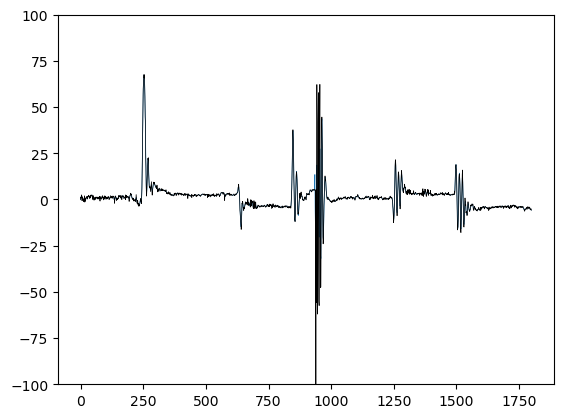

In [7]:
plt.plot(df_smooth[('mtc', 'mtc')], linewidth=0.5)
plt.plot(df_raw[('mtc', 'mtc')], linewidth=0.5, c='k')
plt.ylim([-100, 100])

(0.0, 500.0)

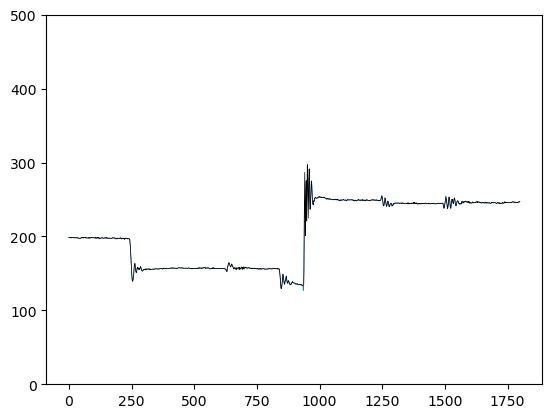

In [8]:
plt.plot(df_smooth[('heading_degrees', 'heading_degrees')], linewidth=0.5)
plt.plot(df_raw[('heading_degrees', 'heading_degrees')], linewidth=0.5, c='k')
plt.ylim([0, 500])

### Test running each function independently

In [9]:
N_TIME_PTS = len(dlc_df)
frames = np.arange(N_TIME_PTS).reshape((-1,1)).astype(np.uint32)
times = frames*(1/FPS)
time_array = np.hstack([frames,times])

In [10]:
time_array

array([[0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.33333333e-03],
       [2.00000000e+00, 6.66666667e-03],
       ...,
       [1.79700000e+03, 5.99000000e+00],
       [1.79800000e+03, 5.99333333e+00],
       [1.79900000e+03, 5.99666667e+00]])

In [11]:
df = compute_base_and_heading(dlc_df, time_array, origin=['swim_bladder'], point=['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom', 'swim_bladder'], truncate=10)

In [12]:
df

Frame      Time      origin                   point              \
       Frame      Time           x           y           x           y   
0        0.0  0.000000   75.014404  146.359161   81.793588  144.119879   
1        1.0  0.003333   75.013344  146.395264   81.696397  144.104694   
2        2.0  0.006667   75.074905  146.291046   81.833937  144.010538   
3        3.0  0.010000   75.097618  146.285187   81.887621  144.025775   
4        4.0  0.013333   75.267921  146.227554   81.888268  144.040347   
...      ...       ...         ...         ...         ...         ...   
1795  1795.0  5.983333  159.099854   34.144356  161.772690   27.865492   
1796  1796.0  5.986667  159.094360   34.124275  161.767987   27.841472   
1797  1797.0  5.990000  159.055817   34.152512  161.788184   27.898395   
1798  1798.0  5.993333  159.113571   34.230087  161.801367   27.932679   
1799  1799.0  5.996667  159.125198   34.097206  161.775989   27.808801   

     heading_vector           heading_degrees  
                  x         y heading_degrees  
0          0.949539 -0.313649      198.279287  
1          0.945979 -0.324228      198.918794  
2          0.947521 -0.319695      198.644480  
3          0.948848 -0.315734      198.405154  
4          0.949522 -0.313700      198.282343  
...             ...       ...             ...  
1795       0.391677 -0.920103      246.941132  
1796       0.391567 -0.920150      246.947978  
1797       0.400350 -0.916362      246.399919  
1798       0.392550 -0.919731      246.886732  
1799       0.388435 -0.921476      247.142817  

[1800 rows x 9 columns]

In [13]:
df = compute_turn_angles(df)

In [14]:
df

Frame      Time      origin                   point              \
       Frame      Time           x           y           x           y   
0        0.0  0.000000   75.014404  146.359161   81.793588  144.119879   
1        1.0  0.003333   75.013344  146.395264   81.696397  144.104694   
2        2.0  0.006667   75.074905  146.291046   81.833937  144.010538   
3        3.0  0.010000   75.097618  146.285187   81.887621  144.025775   
4        4.0  0.013333   75.267921  146.227554   81.888268  144.040347   
...      ...       ...         ...         ...         ...         ...   
1795  1795.0  5.983333  159.099854   34.144356  161.772690   27.865492   
1796  1796.0  5.986667  159.094360   34.124275  161.767987   27.841472   
1797  1797.0  5.990000  159.055817   34.152512  161.788184   27.898395   
1798  1798.0  5.993333  159.113571   34.230087  161.801367   27.932679   
1799  1799.0  5.996667  159.125198   34.097206  161.775989   27.808801   

     heading_vector           heading_degrees turn_angles  
                  x         y heading_degrees turn_angles  
0          0.949539 -0.313649      198.279287         NaN  
1          0.945979 -0.324228      198.918794    0.011162  
2          0.947521 -0.319695      198.644480   -0.004788  
3          0.948848 -0.315734      198.405154   -0.004177  
4          0.949522 -0.313700      198.282343   -0.002143  
...             ...       ...             ...         ...  
1795       0.391677 -0.920103      246.941132    0.002140  
1796       0.391567 -0.920150      246.947978    0.000119  
1797       0.400350 -0.916362      246.399919   -0.009565  
1798       0.392550 -0.919731      246.886732    0.008496  
1799       0.388435 -0.921476      247.142817    0.004470  

[1800 rows x 10 columns]

In [15]:
truncate = 10
# add new columns to df so it later receives the outputs from compute_tail_curvature_metrics()
results_structure = [[],[]]
for i in range(1,truncate+1):
    results_structure[0].extend(['tail_vector_' + str(i), 'tail_vector_' + str(i)])
for i in range(1,truncate+1):
    results_structure[0].extend(['tail_angle_' + str(i)])  

results_structure[1].extend(['x', 'y'] * truncate)
results_structure[1].extend(['angle'] * truncate)
results_structure[0].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
results_structure[1].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
tuples = list(zip(*results_structure))

for column in tuples: 
    df[column] = np.nan

In [16]:
tail_list = []

for coord in ['x', 'y']:
    tail_list.append(('swim_bladder', coord)) 
for i in range(1,10+1):
    for coord in ['x', 'y']:
        tail_list.append(('tail_'+str(i), coord))

tail_list

[('swim_bladder', 'x'),
 ('swim_bladder', 'y'),
 ('tail_1', 'x'),
 ('tail_1', 'y'),
 ('tail_2', 'x'),
 ('tail_2', 'y'),
 ('tail_3', 'x'),
 ('tail_3', 'y'),
 ('tail_4', 'x'),
 ('tail_4', 'y'),
 ('tail_5', 'x'),
 ('tail_5', 'y'),
 ('tail_6', 'x'),
 ('tail_6', 'y'),
 ('tail_7', 'x'),
 ('tail_7', 'y'),
 ('tail_8', 'x'),
 ('tail_8', 'y'),
 ('tail_9', 'x'),
 ('tail_9', 'y'),
 ('tail_10', 'x'),
 ('tail_10', 'y')]

In [17]:
mtc_metrics_smooth = compute_tail_curvature_metrics(df.iloc[:,6:8].values, time_array, dlc_df[scorer][tail_list].values, truncate=10, smooth=9)


smoothing tail angles


c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:54: RuntimeWarning: invalid value encountered in divide
  right = right / right_dx
c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:55: RuntimeWarning: invalid value encountered in divide
  left = left / left_dx


In [18]:
for key, values in mtc_metrics_smooth.items():
    df[key] = values

In [19]:
df

Frame      Time      origin                   point              \
       Frame      Time           x           y           x           y   
0        0.0  0.000000   75.014404  146.359161   81.793588  144.119879   
1        1.0  0.003333   75.013344  146.395264   81.696397  144.104694   
2        2.0  0.006667   75.074905  146.291046   81.833937  144.010538   
3        3.0  0.010000   75.097618  146.285187   81.887621  144.025775   
4        4.0  0.013333   75.267921  146.227554   81.888268  144.040347   
...      ...       ...         ...         ...         ...         ...   
1795  1795.0  5.983333  159.099854   34.144356  161.772690   27.865492   
1796  1796.0  5.986667  159.094360   34.124275  161.767987   27.841472   
1797  1797.0  5.990000  159.055817   34.152512  161.788184   27.898395   
1798  1798.0  5.993333  159.113571   34.230087  161.801367   27.932679   
1799  1799.0  5.996667  159.125198   34.097206  161.775989   27.808801   

     heading_vector           heading_degrees turn_angles  ... tail_angle_4  \
                  x         y heading_degrees turn_angles  ...        angle   
0          0.949539 -0.313649      198.279287         NaN  ...    12.350536   
1          0.945979 -0.324228      198.918794    0.011162  ...    10.542964   
2          0.947521 -0.319695      198.644480   -0.004788  ...    10.050035   
3          0.948848 -0.315734      198.405154   -0.004177  ...    10.513049   
4          0.949522 -0.313700      198.282343   -0.002143  ...    11.573303   
...             ...       ...             ...         ...  ...          ...   
1795       0.391677 -0.920103      246.941132    0.002140  ...    -2.967978   
1796       0.391567 -0.920150      246.947978    0.000119  ...    -3.036476   
1797       0.400350 -0.916362      246.399919   -0.009565  ...    -3.135836   
1798       0.392550 -0.919731      246.886732    0.008496  ...    -3.353388   
1799       0.388435 -0.921476      247.142817    0.004470  ...    -3.776463   

     tail_angle_5 tail_angle_6 tail_angle_7 tail_angle_8 tail_angle_9  \
            angle        angle        angle        angle        angle   
0        5.828268     1.883621    -1.175948     0.764903    -5.911925   
1        4.614353     0.780623    -1.537561    -2.420682     4.096150   
2        4.130445     0.142460    -1.811419    -2.294135     8.524149   
3        4.192549    -0.093406    -1.991367    -0.094023     8.821903   
4        4.616668     0.010490    -2.071251     2.941089     6.439244   
...           ...          ...          ...          ...          ...   
1795     1.607229   -17.485795    -4.211997    -0.588565    -8.242813   
1796     2.033335   -18.072267    -4.160513    -0.428180    -8.618993   
1797     2.114341   -18.371604    -4.129624    -0.354408    -8.761139   
1798     1.557265   -18.168547    -4.213865    -0.524300    -8.569775   
1799     0.069125   -17.247837    -4.507772    -1.094906    -7.945423   

     tail_angle_10       mtc mtc_velocity     mtc_accel  
             angle       mtc mtc_velocity     mtc_accel  
0       -13.174094 -0.146220   161.260547  13123.389373  
1        -6.815323  0.928851   248.749809  -6641.341950  
2        -4.547920  1.512112   116.984934 -34796.154665  
3        -5.209563  1.708750    16.775445 -22675.148277  
4        -7.637934  1.623949   -34.182721 -14273.506312  
...            ...       ...          ...           ...  
1795     -1.043807 -5.356086   -55.172533   6413.817547  
1796     -1.338622 -5.440093   -21.859273   5067.595032  
1797     -1.432364 -5.501814   -21.388567  -1723.234739  
1798     -1.276791 -5.582683   -33.347505     25.706059  
1799     -0.823658 -5.724131   -21.217193   1819.546833  

[1800 rows x 43 columns]

(-6000.0, 6000.0)

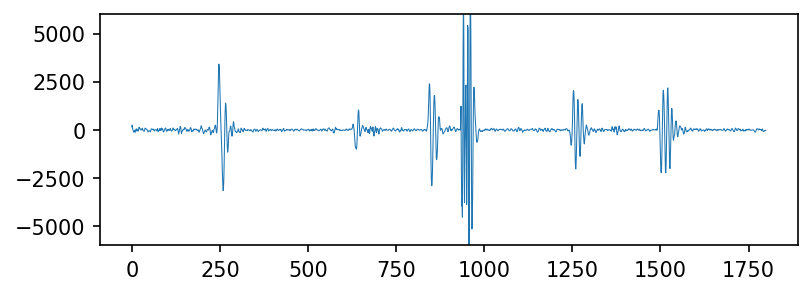

In [20]:
plt.rcParams["figure.figsize"]=(6,2)
plt.rcParams["figure.dpi"]=150
plt.plot(df[('mtc_velocity','mtc_velocity')], linewidth=0.5)
plt.ylim([-6000,6000])

(-600000.0, 600000.0)

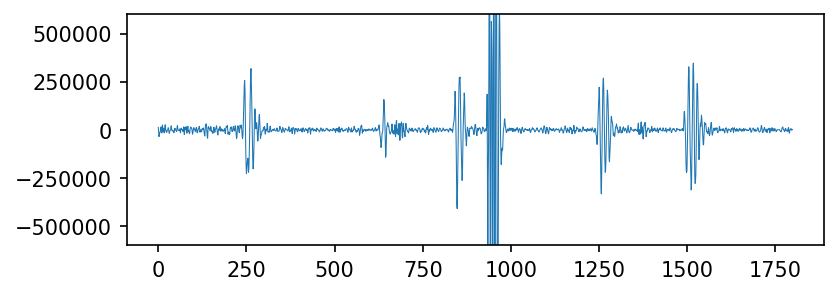

In [21]:
plt.plot(df[('mtc_accel','mtc_accel')], linewidth=0.5)
plt.ylim([-600000,600000])

(-100.0, 100.0)

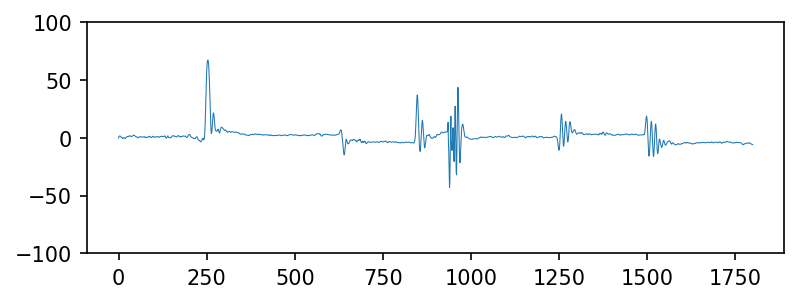

In [22]:
plt.plot(mtc_metrics_smooth[('mtc','mtc')], linewidth=0.5)
plt.ylim([-100,100])

try getting all metrics together


In [23]:
exp_metadata = {'experiment_specs': {'resolution_mmpx': 0.08},
                'camera_specs': {'frame_rate': 300, 
                                 'width': 254}}
bodyparts_dict = {'point_metrics': ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom', 'swim_bladder'], 
                  'vector_metrics':[['swim_bladder'],['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom']]}

all_metrics = get_all_metrics(dlc_df, exp_metadata=exp_metadata, bodyparts_dict=bodyparts_dict, pcutoff=0.8, mask=None, px_tolerances=(0.15,60), movavg=7, vector_smooth=9, truncate_tail_pts=9)



smoothing tail angles


c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:54: RuntimeWarning: invalid value encountered in divide
  right = right / right_dx
c:\Users\lscholz\OneDrive - The University of Melbourne\Documents\repositories\Scholz_et_al_2025_DLC_Analysis\Python\src\dlc_analysis\utils.py:55: RuntimeWarning: invalid value encountered in divide
  left = left / left_dx


In [24]:
all_metrics

Frame      Time mean_body_keypoint                                  \
       Frame      Time                  x           y    x_norm    y_norm   
0        0.0  0.000000          81.793588  144.119879 -0.355956  0.134802   
1        1.0  0.003333          81.696397  144.104694 -0.356721  0.134683   
2        2.0  0.006667          81.833937  144.010538 -0.355638  0.133941   
3        3.0  0.010000          81.887621  144.025775 -0.355216  0.134061   
4        4.0  0.013333          81.888268  144.040347 -0.355210  0.134176   
...      ...       ...                ...         ...       ...       ...   
1795  1795.0  5.983333         161.772690   27.865492  0.273801 -0.780587   
1796  1796.0  5.986667         161.767987   27.841472  0.273764 -0.780776   
1797  1797.0  5.990000         161.788184   27.898395  0.273923 -0.780328   
1798  1798.0  5.993333         161.801367   27.932679  0.274027 -0.780058   
1799  1799.0  5.996667         161.775989   27.808801  0.273827 -0.781033   

                                                       ... tail_angle_3  \
     likelihood dist_travelled  velocity acceleration  ...        angle   
0           1.0       0.000000  1.180440    32.721414  ...    -6.250807   
1           1.0       0.000000  1.398583   195.296533  ...    -3.939384   
2           1.0       0.000000  2.482417   -98.239633  ...    -3.291464   
3           1.0       0.000000  0.743652  -316.264527  ...    -3.838747   
4           1.0       0.000000  0.373987   146.762405  ...    -5.112934   
...         ...            ...       ...          ...  ...          ...   
1795        1.0       0.000000  0.709384    34.978466  ...    -3.603582   
1796        1.0       0.000000  0.436416    68.414617  ...    -3.671824   
1797        1.0       0.000000  1.165482     0.654526  ...    -3.773525   
1798        1.0       0.000000  0.440780  -108.705308  ...    -3.962814   
1799        1.0       0.020232  3.034832   778.215711  ...    -4.293826   

     tail_angle_4 tail_angle_5 tail_angle_6 tail_angle_7 tail_angle_8  \
            angle        angle        angle        angle        angle   
0       12.350536     5.828268     1.883621    -1.175948     0.764903   
1       10.542964     4.614353     0.780623    -1.537561    -2.420682   
2       10.050035     4.130445     0.142460    -1.811419    -2.294135   
3       10.513049     4.192549    -0.093406    -1.991367    -0.094023   
4       11.573303     4.616668     0.010490    -2.071251     2.941089   
...           ...          ...          ...          ...          ...   
1795    -2.967978     1.607229   -17.485795    -4.211997    -0.588565   
1796    -3.036476     2.033335   -18.072267    -4.160513    -0.428180   
1797    -3.135836     2.114341   -18.371604    -4.129624    -0.354408   
1798    -3.353388     1.557265   -18.168547    -4.213865    -0.524300   
1799    -3.776463     0.069125   -17.247837    -4.507772    -1.094906   

     tail_angle_9       mtc mtc_velocity     mtc_accel  
            angle       mtc mtc_velocity     mtc_accel  
0       -5.911925  1.301322    73.198873   8913.034546  
1        4.096150  1.789314   132.619103   4503.257588  
2        8.524149  2.185449   103.220590  -9371.922208  
3        8.821903  2.477452    70.139622 -10389.965275  
4        6.439244  2.653047    33.954155 -13615.312203  
...           ...       ...          ...           ...  
1795    -8.242813 -5.835228   -48.041954   5651.587362  
1796    -8.618993 -5.895812   -17.812128   3486.954430  
1797    -8.761139 -5.953976   -24.795591  -4407.864146  
1798    -8.569775 -6.061116   -47.197889   -949.692485  
1799    -7.945423 -6.268628   -31.126874   2410.652323  

[1800 rows x 51 columns]

In [25]:
dlc_df.shape

(1800, 45)

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\656818713.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(all_metrics[('mtc', 'mtc')], linewidth=0.5)


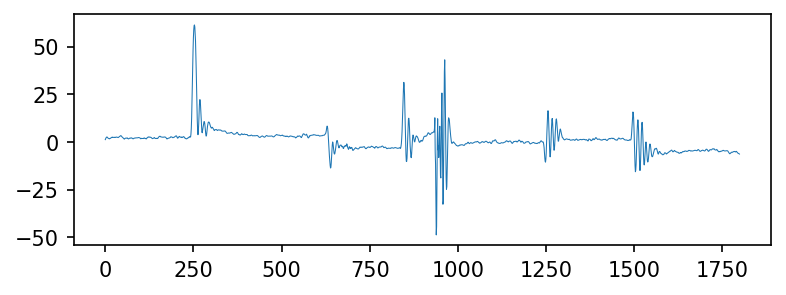

In [26]:
plt.rcParams["figure.figsize"]=(6,2)
plt.rcParams["figure.dpi"]=150
plt.plot(all_metrics[('mtc', 'mtc')], linewidth=0.5)

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\4083431554.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(all_metrics[('heading_degrees', 'heading_degrees')], linewidth=0.5)


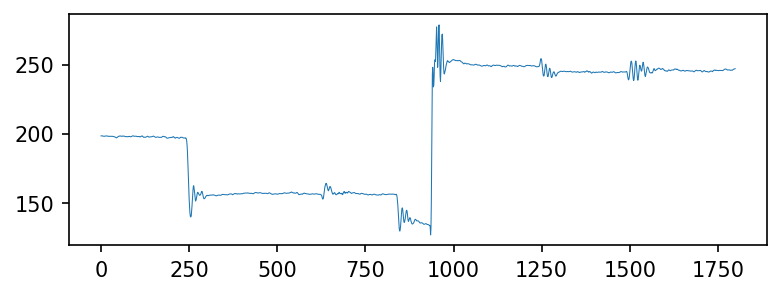

In [27]:
plt.plot(all_metrics[('heading_degrees', 'heading_degrees')], linewidth=0.5)

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3055286669.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(all_metrics[('turn_angles', 'turn_angles')], linewidth=0.5)


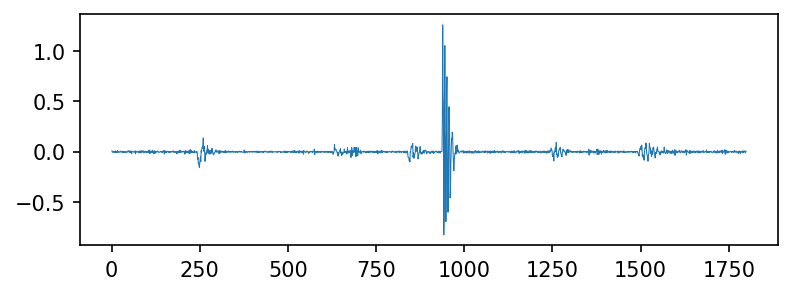

In [28]:
plt.plot(all_metrics[('turn_angles', 'turn_angles')], linewidth=0.5)

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\33664084.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(all_metrics[('mean_body_keypoint', 'dist_travelled')], linewidth=0.5)


(-0.01, 0.5)

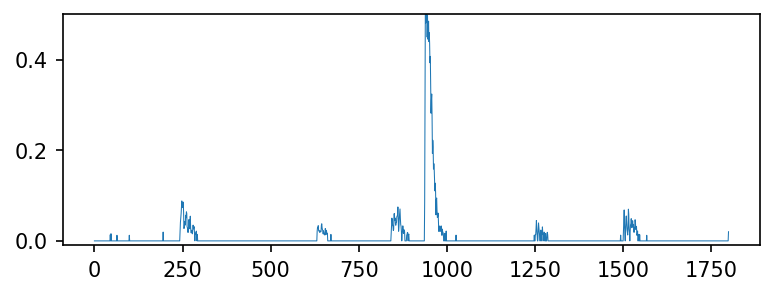

In [29]:
plt.plot(all_metrics[('mean_body_keypoint', 'dist_travelled')], linewidth=0.5)
plt.ylim([-0.01, 0.5])

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3353701456.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(convolve(all_metrics[('mean_body_keypoint', 'dist_travelled')].values.reshape((-1,)), np.ones(9), 'valid') / 9, linewidth=0.5)


(-0.01, 0.5)

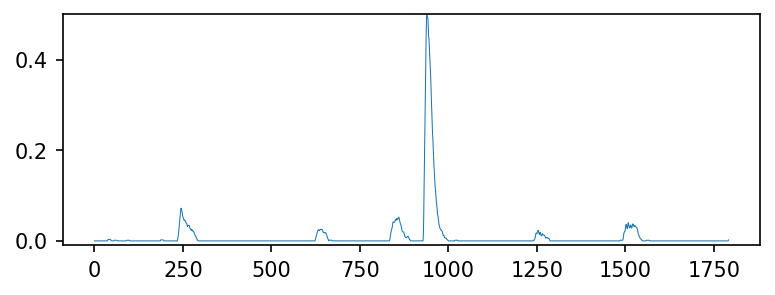

In [30]:
plt.plot(convolve(all_metrics[('mean_body_keypoint', 'dist_travelled')].values.reshape((-1,)), np.ones(9), 'valid') / 9, linewidth=0.5)
plt.ylim([-0.01, 0.5])

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\4288232153.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(all_metrics[('mean_body_keypoint', 'velocity')], linewidth=0.5)


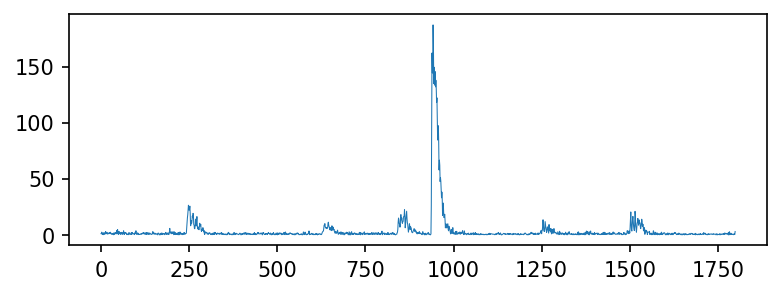

In [31]:
plt.plot(all_metrics[('mean_body_keypoint', 'velocity')], linewidth=0.5)
# plt.xlim([1000,2450])

In [32]:
all_metrics

Frame      Time mean_body_keypoint                                  \
       Frame      Time                  x           y    x_norm    y_norm   
0        0.0  0.000000          81.793588  144.119879 -0.355956  0.134802   
1        1.0  0.003333          81.696397  144.104694 -0.356721  0.134683   
2        2.0  0.006667          81.833937  144.010538 -0.355638  0.133941   
3        3.0  0.010000          81.887621  144.025775 -0.355216  0.134061   
4        4.0  0.013333          81.888268  144.040347 -0.355210  0.134176   
...      ...       ...                ...         ...       ...       ...   
1795  1795.0  5.983333         161.772690   27.865492  0.273801 -0.780587   
1796  1796.0  5.986667         161.767987   27.841472  0.273764 -0.780776   
1797  1797.0  5.990000         161.788184   27.898395  0.273923 -0.780328   
1798  1798.0  5.993333         161.801367   27.932679  0.274027 -0.780058   
1799  1799.0  5.996667         161.775989   27.808801  0.273827 -0.781033   

                                                       ... tail_angle_3  \
     likelihood dist_travelled  velocity acceleration  ...        angle   
0           1.0       0.000000  1.180440    32.721414  ...    -6.250807   
1           1.0       0.000000  1.398583   195.296533  ...    -3.939384   
2           1.0       0.000000  2.482417   -98.239633  ...    -3.291464   
3           1.0       0.000000  0.743652  -316.264527  ...    -3.838747   
4           1.0       0.000000  0.373987   146.762405  ...    -5.112934   
...         ...            ...       ...          ...  ...          ...   
1795        1.0       0.000000  0.709384    34.978466  ...    -3.603582   
1796        1.0       0.000000  0.436416    68.414617  ...    -3.671824   
1797        1.0       0.000000  1.165482     0.654526  ...    -3.773525   
1798        1.0       0.000000  0.440780  -108.705308  ...    -3.962814   
1799        1.0       0.020232  3.034832   778.215711  ...    -4.293826   

     tail_angle_4 tail_angle_5 tail_angle_6 tail_angle_7 tail_angle_8  \
            angle        angle        angle        angle        angle   
0       12.350536     5.828268     1.883621    -1.175948     0.764903   
1       10.542964     4.614353     0.780623    -1.537561    -2.420682   
2       10.050035     4.130445     0.142460    -1.811419    -2.294135   
3       10.513049     4.192549    -0.093406    -1.991367    -0.094023   
4       11.573303     4.616668     0.010490    -2.071251     2.941089   
...           ...          ...          ...          ...          ...   
1795    -2.967978     1.607229   -17.485795    -4.211997    -0.588565   
1796    -3.036476     2.033335   -18.072267    -4.160513    -0.428180   
1797    -3.135836     2.114341   -18.371604    -4.129624    -0.354408   
1798    -3.353388     1.557265   -18.168547    -4.213865    -0.524300   
1799    -3.776463     0.069125   -17.247837    -4.507772    -1.094906   

     tail_angle_9       mtc mtc_velocity     mtc_accel  
            angle       mtc mtc_velocity     mtc_accel  
0       -5.911925  1.301322    73.198873   8913.034546  
1        4.096150  1.789314   132.619103   4503.257588  
2        8.524149  2.185449   103.220590  -9371.922208  
3        8.821903  2.477452    70.139622 -10389.965275  
4        6.439244  2.653047    33.954155 -13615.312203  
...           ...       ...          ...           ...  
1795    -8.242813 -5.835228   -48.041954   5651.587362  
1796    -8.618993 -5.895812   -17.812128   3486.954430  
1797    -8.761139 -5.953976   -24.795591  -4407.864146  
1798    -8.569775 -6.061116   -47.197889   -949.692485  
1799    -7.945423 -6.268628   -31.126874   2410.652323  

[1800 rows x 51 columns]

# Try new bout detector (almost the same as the bout detector in matlab)

In [33]:
bouts = bout_detector(all_metrics, frame_rate=300, smooth_window=5, min_peak_separation=0.1667, min_peak_prominence=0.01, num_repeats=7)

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\2475891748.py:606: PerformanceWarning: indexing past lexsort depth may impact performance.
  distance_mm = all_metrics[(keypt_name, 'dist_travelled')].values
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\2475891748.py:607: PerformanceWarning: indexing past lexsort depth may impact performance.
  acceleration = all_metrics[(keypt_name, 'acceleration')].values
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\2475891748.py:679: PerformanceWarning: indexing past lexsort depth may impact performance.
  window_mtc_std = all_metrics[('mtc', 'mtc')][loc:(loc + bout_window_end)] \


In [34]:
bouts

{'onset': array([ 238,  627,  837,  932, 1243, 1488], dtype=int64),
 'offset': array([ 314,  673,  912, 1008, 1303, 1578], dtype=int64)}

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3455294789.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[0].plot(all_metrics[('mean_body_keypoint', 'dist_travelled')].rolling(9).mean(), linewidth=0.5)
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3455294789.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[1].plot(all_metrics[('mtc', 'mtc')].rolling(3).mean(), linewidth=0.5, c='orange')
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3455294789.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[2].plot(all_metrics[('mtc', 'mtc')].rolling(9).std(), linewidth=0.5, c='g')
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3455294789.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[3].plot(all_metrics[('turn_angles', 'turn_angles')], linewidth=0.5, c='g')


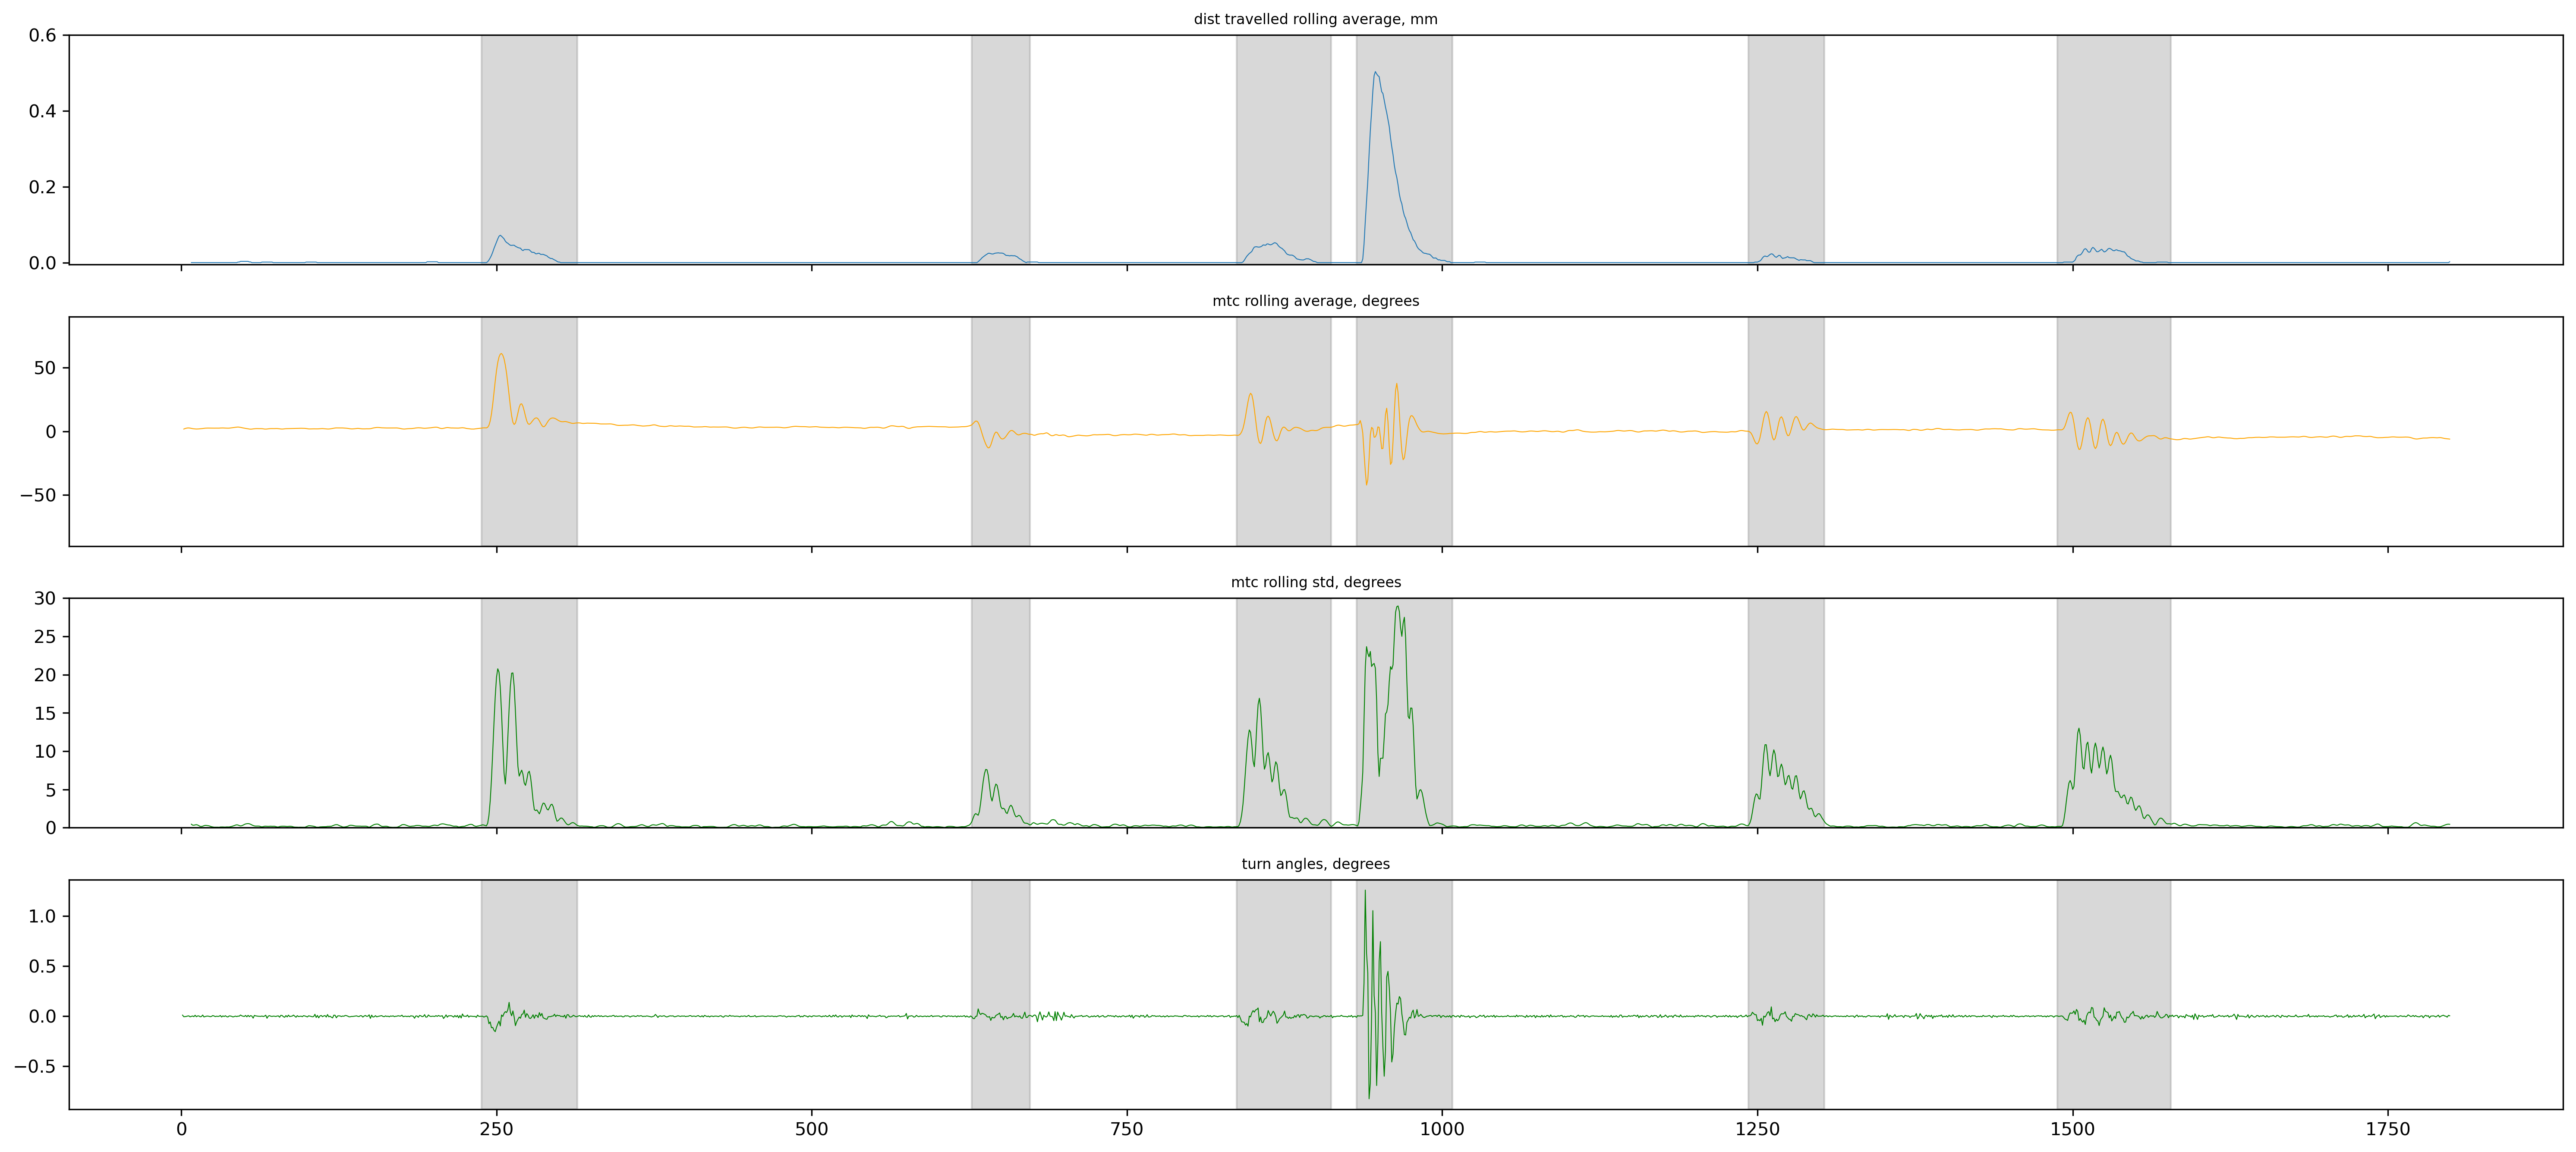

In [35]:
font_properties = {'family':'sans', 'size':8}
fontdict=font_properties
plt.rcParams["figure.figsize"] = (20,9)
plt.rcParams["figure.dpi"] = 300

fig, ax = plt.subplots(4,1,sharex=True)
ax[0].plot(all_metrics[('mean_body_keypoint', 'dist_travelled')].rolling(9).mean(), linewidth=0.5)
ax[1].plot(all_metrics[('mtc', 'mtc')].rolling(3).mean(), linewidth=0.5, c='orange')
ax[2].plot(all_metrics[('mtc', 'mtc')].rolling(9).std(), linewidth=0.5, c='g')
ax[3].plot(all_metrics[('turn_angles', 'turn_angles')], linewidth=0.5, c='g')

# ax[0].set_xlim([0,8000])
ax[0].set_ylim([-0.005,0.6])
ax[1].set_ylim([-90,90])
ax[2].set_ylim([0,30])
ax[0].set_title('dist travelled rolling average, mm', fontdict=font_properties)
ax[1].set_title('mtc rolling average, degrees', fontdict=font_properties)
ax[2].set_title('mtc rolling std, degrees', fontdict=font_properties)
ax[3].set_title('turn angles, degrees', fontdict=font_properties)

# I have two vectors that give when an event starts and when an event ends and I want to highlight these in the plots
# would fill_betweenx() do that? 
#ax[0].fill_betweenx()

for start, end in zip(bouts['onset'], bouts['offset']):
    # Loop through each subplot axis
    for subplot_ax in ax:
        # Draw the vertical span (rectangle)
        subplot_ax.axvspan(
            start, end,          # The x-range to shade
            color='grey',        # The color of the_shade
            alpha=0.3,           # The transparency of the shade
            zorder=0             # Set zorder to 0 to draw behind the plot lines
        )

plt.tight_layout()
plt.show()

# try the function that computes all bout metrics

In [36]:
def compute_bout_metrics(all_metrics_df:pd.DataFrame,
                         onset_offset: tuple,
                         FPS=1,
                         smooth_point=None, 
                         smooth_vector= None,
                         smooth_vigor_window=40) -> dict:
    """_summary_

    Args:
        all_metrics_df (pd.DataFrame): _description_
        bouts_dict (dict): _description_
        FPS (int, optional): _description_. Defaults to 1.
        smooth_params (_type_, optional): _description_. Defaults to None.
    """
    # Get main keypoint name
    keypt_name = all_metrics_df.columns.get_level_values(0)[2]

    if smooth_point[0] == 'mean':
        window = int(smooth_point[1] / (1000*(1/FPS)))
        dt_values = quick_smooth(all_metrics_df[(keypt_name, 'dist_travelled')].values, smooth_val=window)
        velocity = quick_smooth(all_metrics_df[(keypt_name, 'velocity')].values,  smooth_val=window)
        acceleration = quick_smooth(all_metrics_df[(keypt_name, 'acceleration')].values,  smooth_val=window)

    if smooth_point is None:
        dt_values = all_metrics_df[(keypt_name, 'dist_travelled')]
        velocity = all_metrics_df[(keypt_name, 'velocity')]
        acceleration = all_metrics_df[(keypt_name, 'acceleration')]

    if smooth_vector[0] == 'mean':
        window = int(smooth_vector[1] / (1000*(1/FPS)))
        mtc = all_metrics_df[('mtc', 'mtc')].rolling(window).mean().values.reshape((-1,))
        mtc_velocity = all_metrics_df[('mtc_velocity', 'mtc_velocity')] \
            .rolling(window).mean().values.reshape((-1,))
        turn_angles =  all_metrics_df[('turn_angles', 'turn_angles')] \
            .rolling(window).mean().values.reshape((-1,))
        heading = all_metrics_df[('heading_degrees', 'heading_degrees')] \
            .rolling(window).mean().values.reshape((-1,))

    if smooth_vector is None:
        mtc = all_metrics_df[('mtc', 'mtc')].values.reshape((-1,))
        mtc_velocity = all_metrics_df[('mtc_velocity', 'mtc_velocity')].values.reshape((-1,))
        turn_angles =  all_metrics_df[('turn_angles', 'turn_angles')].values.reshape((-1,))
        heading = all_metrics_df[('heading_degrees', 'heading_degrees')].values.reshape((-1,))

    onset = onset_offset[0]
    offset = onset_offset[1]

    # HERE THE COMPUTATIONS START
    # compute bout duration in miliseconds
    duration = all_metrics_df.iloc[offset, 1] - all_metrics_df.iloc[onset, 1]
    duration = duration * 1000
    
    # whole-body displacement related (point-based metrics)
    total_distance = np.nansum(dt_values[onset:offset])
    average_speed = total_distance / duration/1000
    max_point_speed = np.nanmax(velocity[onset:offset])
    max_point_accel = np.nanmax(acceleration[onset:offset])

    # tail related (vector-based)
    mean_mtc = np.nanmean(mtc[onset:offset])
    max_point_mtc = np.nanmax(mtc[onset:offset])
    min_point_mtc = np.nanmin(mtc[onset:offset]) 
    max_abs_point_mtc = np.nanmax(np.abs(mtc[onset:offset]))
    bout_symmetry = (max_point_mtc + min_point_mtc) / (max_point_mtc - min_point_mtc)

    max_mtc_velocity = np.nanmax(mtc_velocity[onset:offset])
    mean_mtc_velocity = np.nanmean(np.abs(mtc_velocity[onset:offset]))

    tail_beat_fft = fft(detrend(mtc[onset:offset]), n=300) 
    frequencies = fftfreq(300, 1/FPS)
    pos_freq_mask = frequencies > 0
    dominant_tailbeat_freq = frequencies[np.argmax(np.abs(tail_beat_fft[pos_freq_mask])**2)]

    # tail segment related (vector-based)
    tail_angle_names = [var for var in all_metrics_df.columns.get_level_values(0) \
                        if 'tail_angle_' in var]
    columns = zip(tail_angle_names, ['angle']*(len(tail_angle_names)))
    tail_max_amplitude = np.max(np.abs(all_metrics_df[columns].values[onset:offset]), axis=0)

    #vigor related 
    # vigor degrees/s 
    total_vigor = np.sum(np.abs(np.diff(mtc_velocity[onset:offset], prepend=0)))
    # max vigor calculated by finding the maximum instantaneous vigor using a window 
    window = int(smooth_vigor_window / (1000*(1/FPS)))
    moving_vigor = quick_smooth(np.abs(np.diff(mtc_velocity[onset:offset])), smooth_val=window)
    max_point_vigor = np.nanmax(moving_vigor)
    mean_vigor = np.nanmean(moving_vigor)

    #heading related (vector-based)
    max_turn_angle = np.max(np.abs(turn_angles[onset:offset]))
    bout_end_angle = np.abs(heading[onset]  \
                            - heading[offset])
    bout_end_angle2 = 360 - bout_end_angle 
    bout_end_angle = np.min([bout_end_angle, bout_end_angle2], axis=0)

    bout_dict = {'onset': onset_offset[0],
                 'offset': onset_offset[1]}
    
    bout_dict.update({'duration': duration,                         # in miliseconts
                      'total_distance': total_distance,             # in milimeters
                      'avg_speed': average_speed,                   # in mm.s^-1
                      'max_speed': max_point_speed,                 # in mm.s^-1
                      'max_acceleration': max_point_accel,          # in mm.s^-2
                      'avg_mtc': mean_mtc,                          # in degrees
                      'max_abs_mtc': max_abs_point_mtc,             # in degrees
                      'bout_symmetry': bout_symmetry,               # dimensionless 
                      'max_mtc_velocity': max_mtc_velocity,         # in degrees.s^-1
                      'avg_mtc_velocity': mean_mtc_velocity,        # in degrees.s^-1
                      'tailbeat_frequency': dominant_tailbeat_freq, # in Hz, dominant tailbeat frequency
                      'total_vigor': total_vigor,                   # in degrees.s^-1
                      'max_vigor': max_point_vigor,                 # in degrees.s^-1
                      'avg_vigor': mean_vigor,                      # in degrees.s^-1
                      'max_turn_angle': max_turn_angle,             # in degrees
                      'bout_end_angle': bout_end_angle 
                      })
    bout_dict.update({'max_tail_amplitude_'+str(i+1) : tail_max_amplitude[i] \
                       for i in range(len(tail_angle_names))})

    return bout_dict

In [37]:
test = compute_bout_metrics(all_metrics, onset_offset=(932,1008), FPS=300, smooth_point=('mean',30), smooth_vector=('mean',10), smooth_vigor_window=44)

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  dt_values = quick_smooth(all_metrics_df[(keypt_name, 'dist_travelled')].values, smooth_val=window)
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  velocity = quick_smooth(all_metrics_df[(keypt_name, 'velocity')].values,  smooth_val=window)
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  acceleration = quick_smooth(all_metrics_df[(keypt_name, 'acceleration')].values,  smooth_val=window)
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  mtc = all_metrics_df[('mtc', 'mtc')].rolling(window).mean().values.reshape((-1,))
C:\Users\lscholz\AppData\Local\Temp\ipykernel_166

In [38]:
test

{'onset': 932,
 'offset': 1008,
 'duration': 253.3333333333334,
 'total_distance': 11.438166524689322,
 'avg_speed': 4.515065733429995e-05,
 'max_speed': 151.04685016456108,
 'max_acceleration': 5927.612225595606,
 'avg_mtc': -1.2127831254238246,
 'max_abs_mtc': 42.14966792368481,
 'bout_symmetry': -0.05710718716077118,
 'max_mtc_velocity': 5996.546181352627,
 'avg_mtc_velocity': 1416.319174239643,
 'tailbeat_frequency': 29.0,
 'total_vigor': 77125.35441130814,
 'max_vigor': 2677.923081545031,
 'avg_vigor': 1108.8238063163772,
 'max_turn_angle': 0.7731953148612224,
 'bout_end_angle': 118.89019118412983,
 'max_tail_amplitude_1': 16.13885116004704,
 'max_tail_amplitude_2': 32.038285847901186,
 'max_tail_amplitude_3': 38.51102292492474,
 'max_tail_amplitude_4': 57.67917916082913,
 'max_tail_amplitude_5': 85.65856216184844,
 'max_tail_amplitude_6': 101.84150283615313,
 'max_tail_amplitude_7': 59.2666684376529,
 'max_tail_amplitude_8': 70.88107409349908,
 'max_tail_amplitude_9': 68.11169062

In [39]:
test = compute_bout_metrics(all_metrics, onset_offset=(238,314), FPS=300, smooth_point=('mean',30), smooth_vector=('mean',10), smooth_vigor_window=44)

C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  dt_values = quick_smooth(all_metrics_df[(keypt_name, 'dist_travelled')].values, smooth_val=window)
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  velocity = quick_smooth(all_metrics_df[(keypt_name, 'velocity')].values,  smooth_val=window)
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  acceleration = quick_smooth(all_metrics_df[(keypt_name, 'acceleration')].values,  smooth_val=window)
C:\Users\lscholz\AppData\Local\Temp\ipykernel_16636\3971737758.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  mtc = all_metrics_df[('mtc', 'mtc')].rolling(window).mean().values.reshape((-1,))
C:\Users\lscholz\AppData\Local\Temp\ipykernel_166

In [40]:
test

{'onset': 238,
 'offset': 314,
 'duration': 253.3333333333333,
 'total_distance': 1.8212844229609195,
 'avg_speed': 7.189280616950999e-06,
 'max_speed': 21.63937087684454,
 'max_acceleration': 787.9659494587734,
 'avg_mtc': 15.56885279462798,
 'max_abs_mtc': 61.002792190607884,
 'bout_symmetry': 1.0835040405840075,
 'max_mtc_velocity': 2737.6073441917156,
 'avg_mtc_velocity': 661.8478759161155,
 'tailbeat_frequency': 6.0,
 'total_vigor': 19309.770733438574,
 'max_vigor': 534.946294723017,
 'avg_vigor': 283.0556175515232,
 'max_turn_angle': 0.13558362918657837,
 'bout_end_angle': 41.23472498541358,
 'max_tail_amplitude_1': 24.45063377423749,
 'max_tail_amplitude_2': 26.210939740028586,
 'max_tail_amplitude_3': 43.54357943346629,
 'max_tail_amplitude_4': 60.02441511466094,
 'max_tail_amplitude_5': 64.00371771782919,
 'max_tail_amplitude_6': 76.90706431176179,
 'max_tail_amplitude_7': 84.73874279758859,
 'max_tail_amplitude_8': 96.63687473858361,
 'max_tail_amplitude_9': 117.4971985209170